# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
- convert the tracksters into some latent space and predict a link between them

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from reco.training import precision_recall_curve, roc_auc

from torch.utils.data import random_split, DataLoader
from reco.loss import QualityFocalLoss

from reco.datasetPU import TracksterPairs


ds_name = "CloseByTwoPion"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

# writer = SummaryWriter()

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=30,
    radius=30,
    bigT_e_th=75,
)

ds.x.shape

torch.Size([111969, 63])

In [4]:
print(ds.x.shape)
print("Positive:", int((ds.y >= 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.5).type(torch.int).sum()))

torch.Size([111969, 63])
Positive: 69458
Negative: 42511


In [5]:
balance =  float(sum(ds.y > 0.5) / len(ds.y))
print("dataset balance:", balance) 

dataset balance: 0.6203324198722839


In [6]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 100773, Test samples: 11196


In [7]:
loss_obj = QualityFocalLoss(gamma=2)

def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == (labels > 0.5).type(torch.int))
    return (correct / total)

In [8]:
hdim1 = 256
hdim2 = 128

model = nn.Sequential(
    nn.LayerNorm(ds.x.shape[1]),      # normalization as a part of the network
    nn.Linear(ds.x.shape[1], hdim1),
    nn.Sigmoid(),
    nn.Linear(hdim1, hdim2),
    nn.Sigmoid(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
).to(device)

epochs = 100
model_path = f"models/PairWiseMLP.QFL.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}r.{ds.bigT_e_th}eth.{ds.N_FILES}f.pt"

In [9]:
#%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

In [86]:
#%%script echo skipping
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
loss_obj = QualityFocalLoss(gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, test auc: {test_auc:.4f}')

Epoch: 0, loss: 174.3277, train auc: 0.9113, test auc: 0.9103
Epoch: 5, loss: 131.0866, train auc: 0.9148, test auc: 0.9144
Epoch: 10, loss: 127.7658, train auc: 0.9160, test auc: 0.9153
Epoch: 15, loss: 125.4713, train auc: 0.9191, test auc: 0.9183
Epoch: 20, loss: 122.1820, train auc: 0.9245, test auc: 0.9240
Epoch: 25, loss: 119.8990, train auc: 0.9275, test auc: 0.9272
Epoch: 30, loss: 118.9746, train auc: 0.9284, test auc: 0.9284
Epoch: 35, loss: 118.5359, train auc: 0.9299, test auc: 0.9296
Epoch: 40, loss: 116.5739, train auc: 0.9297, test auc: 0.9291
Epoch: 45, loss: 115.6351, train auc: 0.9325, test auc: 0.9323
Epoch: 50, loss: 115.2551, train auc: 0.9306, test auc: 0.9289
Epoch: 55, loss: 114.7737, train auc: 0.9322, test auc: 0.9317
Epoch: 60, loss: 114.1329, train auc: 0.9334, test auc: 0.9332
Epoch: 65, loss: 113.2297, train auc: 0.9348, test auc: 0.9340
Epoch: 70, loss: 113.8359, train auc: 0.9354, test auc: 0.9347
Epoch: 75, loss: 113.1901, train auc: 0.9349, test auc: 0

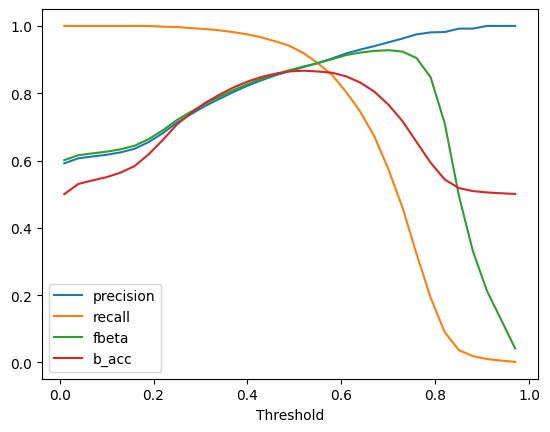

TP: 3808, TN: 4378, FP: 195, FN: 2815
TH: 0.7 precision: 0.951 recall: 0.575 fbeta: 0.928 b_acc: 0.766


In [87]:
#%%script echo skipping
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.2, step=3)

In [88]:
#%%script echo skipping
torch.save(model.state_dict(), model_path)

# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [10]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import pairwise_model_evaluation

from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15101852_0.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [121]:
r_ranges = range(5, 45, 5)
results = []

clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = pairwise_model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=0.8,
        radius=r,
        max_events=20,
        reco_to_target=False,
        bigT_e_th=75,
    )
    clue3D_F.append(np.mean(np.array(result["clue3d_to_sim"])[:,2]))
    target_F.append(np.mean(np.array(result["target_to_sim"])[:,2]))
    naive_reco_F.append(np.mean(np.array(result["reco_to_sim"])[:,2]))

    result = pairwise_model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=20,
        reco_to_target=False,
        bigT_e_th=75,
    )
    model_reco_F.append(np.mean(np.array(result["reco_to_sim"])[:,2]))

 --- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.969 R: 0.134 F: 0.781
	target_to_sim:	P: 0.969 R: 0.330 F: 0.902
	reco_to_sim:	P: 0.969 R: 0.330 F: 0.902
	No data
Event 2:
	clue3d_to_sim:	P: 0.996 R: 0.108 F: 0.757
	target_to_sim:	P: 0.996 R: 0.117 F: 0.773
	reco_to_sim:	P: 0.996 R: 0.117 F: 0.773
Event 3:
	clue3d_to_sim:	P: 0.979 R: 0.117 F: 0.763
	target_to_sim:	P: 0.980 R: 0.487 F: 0.943
	reco_to_sim:	P: 0.980 R: 0.487 F: 0.943
Event 4:
	clue3d_to_sim:	P: 0.989 R: 0.112 F: 0.760
	target_to_sim:	P: 0.989 R: 0.407 F: 0.938
	reco_to_sim:	P: 0.991 R: 0.415 F: 0.941
Event 5:
	clue3d_to_sim:	P: 0.982 R: 0.257 F: 0.886
	target_to_sim:	P: 0.982 R: 0.499 F: 0.947
	reco_to_sim:	P: 0.982 R: 0.499 F: 0.947
Event 6:
	clue3d_to_sim:	P: 0.977 R: 0.090 F: 0.709
	target_to_sim:	P: 0.975 R: 0.275 F: 0.888
	reco_to_sim:	P: 0.975 R: 0.275 F: 0.888
	No data
Event 8:
	clue3d_to_sim:	P: 0.985 R: 0.113 F: 0.760
	target_to_sim:	P: 0.985 R: 0.320 F: 0.912
	reco_to_sim:	P: 0.985 R: 0.320 F: 0.912
E

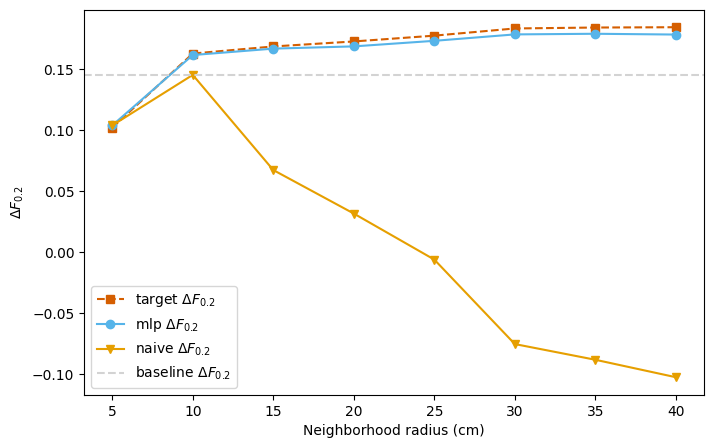

In [124]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges, np.array(target_F) - np.array(clue3D_F), '--s', label="target $\Delta F_{0.2}$", c="#D55E00")
ax.plot(r_ranges, np.array(model_reco_F) - np.array(clue3D_F), '-o', label="mlp $\Delta F_{0.2}$", c="#56B4E9")
ax.plot(r_ranges, np.array(naive_reco_F) - np.array(clue3D_F), '-v', label="naive $\Delta F_{0.2}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline $\Delta F_{0.2}$", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.2}$")

fig.savefig('export/two-pions-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [133]:
max(np.array(naive_reco_F) - np.array(clue3D_F))

0.14537102951326897

In [ ]:
fig = plt.figure(figsize=(8, 5))
eth_ranges = range(0, 100, 10)

ax = fig.add_subplot(111)

for r, res in zip(r_ranges[:3], results[:3]):
    ax.plot(eth_ranges, res, label=f"{r} cm radius")

ax.legend()
ax.set_xlim(0, 95)
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("$\Delta F_{0.2}$")

#fig.savefig('export/two-pion-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()